### _imports_ 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests

from PIL import Image
from matplotlib import patches
from io import BytesIO

# 1. Microsoft Face API

In [2]:
subscription_key = 'bbacb1a9cef84bca9ac5c44b036c8987'
assert subscription_key

face_api_url = 'https://westcentralus.api.cognitive.microsoft.com/face/v1.0/detect'

headers = { 'Ocp-Apim-Subscription-Key': subscription_key }
    
params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}


Используем функцию `annotate_image` [из примера](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python) от Microsoft - [MyBinder](https://mybinder.org/v2/gh/Microsoft/cognitive-services-notebooks/master?filepath=FaceAPI.ipynb) - с небольшой модификацией.

In [3]:
def annotate_image(image_url, rows, cols, idx):
    response = requests.post(face_api_url, params=params, headers=headers, json={"url": image_url})
    faces = response.json()

    image_file = BytesIO(requests.get(image_url).content)
    image = Image.open(image_file)

    ax = plt.imshow(image, alpha=0.6)
    for face in faces:
        fr = face["faceRectangle"]
        fa = face["faceAttributes"]
        origin = (fr["left"], fr["top"])
        p = patches.Rectangle(origin, fr["width"], \
                              fr["height"], fill=False, linewidth=2, color='b')
        ax.axes.add_patch(p)
        plt.text(origin[0], origin[1], "%s, %d"%(fa["gender"].capitalize(), fa["age"]), \
                 fontsize=20, weight="bold", va="bottom")
    plt.axis("off")

In [4]:
def detect_face(urls):
    ncols = 3
    nrows = (len(urls) // ncols) + (0 < len(urls) % ncols)
    fig = plt.figure(figsize=(8 * ncols, 6 * nrows))
    for idx, url in enumerate(urls):
        fig.add_subplot(nrows, ncols, idx + 1)
        annotate_image(url, nrows, ncols, idx + 1)

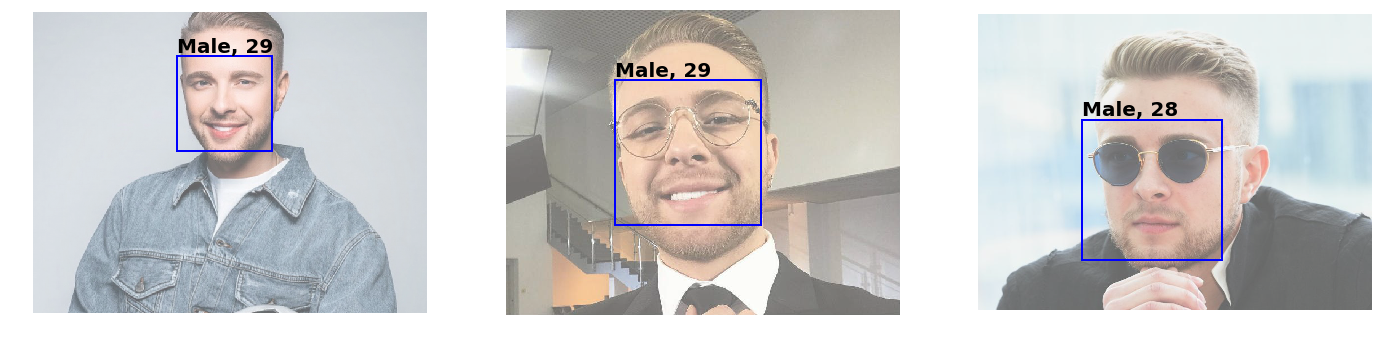

In [5]:
egor_krid = [
    'https://hochu.ua/thumbnails/articles/cropr_640x490/86492_0.jpg',
    'https://s5.cdn.teleprogramma.pro/wp-content/uploads/2017/12/aabc2dd4c974dad343a3c6ea1dd298fe.jpg',
    'https://sobesednik.ru/storage/posts/September2018/STTcBonFD2oIFiYNTaUE.jpg'
]

detect_face(egor_krid);

\* по данным [Wikipedia](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D0%B4,_%D0%95%D0%B3%D0%BE%D1%80) ему на сегодняшний день 24 года.

# 2. Yandex SpeechKit

К сожалению, текст из песен очень плохо распознаётся, поэтому я решил поработать с [аудиокнигой](https://archive.org/details/troe_v_lodke_ne_shitaia_sobaki): фрагмент 1-й главы [Джером К. Джером - Трое в лодке, не считая собаки](http://read.newlibrary.ru/read/dzherom_k__dzherom/troe_v_lodke_ne_schitaja_sobaki.html).

\* На куски <1Мб разбивал с помощью shareware аудио-редактора [WavePad](https://www.nch.com.au/wavepad/index.html).

In [6]:
import xml.etree.ElementTree as ET
import uuid

KEY = '<KEY>'
UUID=uuid.uuid4().hex

In [7]:
speech_kit_url = 'https://asr.yandex.net/asr_xml?key=' + KEY + '&uuid=' + UUID + '&topic=queries&lang=ru-RU'
headers = {"Content-Type": 'audio/x-mpeg-3'}

text = []

for chunk in range(0, 11):
    with open('jerome/Глава 01_{:02d}.mp3'.format(chunk), 'rb') as mp3:    
        response = requests.post(speech_kit_url, headers=headers, data=mp3)
        if 200 != response.status_code:
            continue
        result = ET.fromstring(response.text)
#         print(chunk, result.attrib['success'])
        if bool(result.attrib['success']):
            text.append([ variant.text for variant in result ])

In [8]:
list(zip(*[block for block in text]))[0]

('суд джером клапка джером трое в лодке не считая собаки предисловии автор главное достоинство нашей книги это не ее литературу и даже не',
 'содержащихся в ней разного рода полезных сведений о ее правдивость странице этой книги представляет собой беспристрастный отчет о действительно происходивших событиях работа автора к тому чтобы несколько оживить повествование за этого не требует себе особого вознаграждений джон гаррисон монморанси отнюдь не поэтический идеал но существа из плоти и крови',
 'особенности джордж который весит около 170£ быть может другие труды превосходят наш труд глубину мыслей и проникновением в природу человек быть может другие книги могут соперничать с нашей книгой оригинальностью и объемом но что касается безнадежный закоренелый и правдивости не вышедшая в свет на сегодня печатное произведение не может сравниться с этой повести мне сомневаешься что упомянутая',
 '100 больше чем какое либо другое привлечет к нашему труду внимание серьезного читателя и повысят в 

# 3. FastText

_Попробую сделать, если будет время._